In [1]:
import json
import pandas as pd
import os
import shutil
import re
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np
from IPython.core.display import display, HTML
# below you need to set up for linux
# import plotly.io as pio
# pio.orca.config.use_xvfb = True
# pio.orca.config.save() 

In [2]:
def read_file(file):
    date = []
    ip = []
    status = []
    netLocalPeer = []
    connLocalPeer = []
    connLocalAddr = []
    connRemotePeer = []
    connRemoteAddr = []
    streamProtocolID = []
    with open(file, errors='ignore') as f:
        for line in f.readlines():
            date.append(line.partition("]")[0].partition("DEBUG[")[2])
            status.append(line.partition("port")[0].partition("]")[2].strip())
            pattern = re.compile(".*?=(.*?) .*?")
            tmp = re.findall(pattern, line)
            ip.append(tmp[1])
            netLocalPeer.append(tmp[2])
            connLocalPeer.append(tmp[4])
            connLocalAddr.append(tmp[5])
            connRemotePeer.append(tmp[6])
            connRemoteAddr.append(tmp[7])
            if len(tmp) == 11:
                streamProtocolID.append(tmp[8])
            else:
                streamProtocolID.append("")
            
    key_word = ['date', 'ip', 'status', 'netLocalPeer', 'connLocalPeer', 'connLocalAddr', 'connRemotePeer', 'connRemoteAddr', 'streamProtocolID']
    lst = [date, ip, status, netLocalPeer, connLocalPeer, connLocalAddr, connRemotePeer, connRemoteAddr, streamProtocolID]
    df = pd.DataFrame(zip(*lst), columns = key_word)
    return df

In [3]:
def get_top_10_frequent(df, name):
    sort_df = df.sort_values(by='count', ascending = False).reset_index(drop = True) 
    lst = sort_df.loc[:9, name].tolist()
    return lst

In [4]:
def aggregate_value(df, name, lst):
    mask = df[name].apply(lambda x: x in lst)
    df_2 = df[mask]
    five_minute = df_2.groupby([pd.Grouper(freq='5Min', key = 'date'), name])[name].count().reset_index(name = 'count')
    five_minute = five_minute.sort_values(by='count', ascending = False).reset_index(drop = True) 
    return five_minute

In [5]:
def draw_graph(df, group, alert):
    
    df = df.sort_values(by='date').reset_index(drop = True)
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../docs/", "") + group + ".html"
    png_path = fig_dir 
    print("png graphs saved in " + png_path)
    print('html graphs saved in ')
    display(HTML("<a href='" + html_path + "' target='_blank'>" + html_path + "</a>"))
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    hover = df.columns.tolist()
    fig = px.line(df, x="date", y="count", color=group, color_discrete_sequence=px.colors.cyclical.Twilight, \
              title = group + ' visit times in five minutesvs Time', hover_data=hover)
    fig.update_layout(xaxis_title="utc_time", legend_orientation="h", legend=dict(x=-0.2, y=-0.25))
    
    trace = []
    text = []
    for k,v in alert.items():
        fig.add_shape(type="line", x0=k, y0=0,x1=k,y1=1,
                line=dict(
                width=0.5,
                dash="dot",
                
            ))
        trace.append(k)
        text.append(v)
    fig.update_shapes(dict(xref='x', yref='paper'))
    
    fig.add_trace(go.Scatter(
        x=trace,
        y=np.linspace(1, df['count'].max(), num = len(alert)).tolist(),
        text=text,
        mode="text",
        showlegend=False
    ))
    

    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_dir + group + ".html")
    fig.write_image(png_path + group + ".png",width=1000, height=600)

In [6]:
# get alert time from pagerduty
alert = dict()
alert['2020-03-31 11:24:18.0'] = 'Shard 0 stuck!'
alert['2020-03-31 11:16:47.0'] = 'Shard 2 stuck!'
alert['2020-03-31 07:15:15.0'] = 'Shard 3 stuck!'
alert['2020-03-31 07:15:24.0'] = 'Shard 1 stuck!'
alert['2020-03-30 20:52:40.0'] = 'Shard 0 stuck!'
alert['2020-03-30 20:52:32.0'] = 'Shard 2 stuck!'
alert['2020-03-30 20:52:37.0'] = 'Shard 3 stuck!'
alert['2020-03-30 20:52:31.0'] = 'Shard 1 stuck!'

In [7]:
file = "../../logs/bootnode/sample.log"
df = read_file(file)
df['date'] = df['date'].apply(lambda r: "2020-"+r)
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d|%H:%M:%S.%f')

In [8]:
html_dir = "../../docs/graphs/crash_analysis/mainnet/03-31/100.26.90.187-bootnode/"
fig_dir = "../../graphs/crash_analysis/mainnet/03-31/100.26.90.187-bootnode/"

## basic statistics info

Date range (UTC) 2020-03-29 00:01:52.144000 - 2020-04-01 19:16:54.162000

Total data points: 316100

- Unique Ip address: 100.26.90.187
- Unique netLocalPeer: Qmdfjtk6hPoyrH1zVD9PEH4zfWLo38dP2mDvvKXfh3tnEv
- Unique connLocalPeer: Qmdfjtk6hPoyrH1zVD9PEH4zfWLo38dP2mDvvKXfh3tnEv
- 3 types of connLocalAddr
- 4 type of status: connected, disconnected, stream closed, stream opened
- 5 type streamProtocolID,  with 181742 among missing info
- 594 connRemotePeer
- 757 connRemoteAddr


In [9]:
print("start time: ", df.date.iloc[-1], "end time: ", df.date.iloc[0])
print("total data points:", len(df))
print("ip: ", set(df.ip))
print("netLocalPeer: ", set(df.netLocalPeer))
print("connLocalPeer: ", set(df.connLocalPeer))
print('status: ', set(df.status))

start time:  2020-03-29 00:01:52.144000 end time:  2020-04-01 19:16:54.162000
total data points: 316100
ip:  {'100.26.90.187'}
netLocalPeer:  {'Qmdfjtk6hPoyrH1zVD9PEH4zfWLo38dP2mDvvKXfh3tnEv'}
connLocalPeer:  {'Qmdfjtk6hPoyrH1zVD9PEH4zfWLo38dP2mDvvKXfh3tnEv'}
status:  {'stream closed', 'stream opened', 'connected', 'disconnected'}


In [10]:
df.groupby('status')['status'].count()

status
connected          4425
disconnected       4439
stream closed    153639
stream opened    153597
Name: status, dtype: int64

In [11]:
df.groupby('streamProtocolID')['streamProtocolID'].count().reset_index(name = 'count')

,streamProtocolID,count
0,,181742
1,/ipfs/id/1.0.0,8846
2,/ipfs/id/push/1.0.0,19194
3,/ipfs/kad/1.0.0,97457
4,/meshsub/1.0.0,8857
5,/p2p/id/delta/1.0.0,4


In [12]:
df.groupby('connLocalAddr')['connLocalAddr'].count()

connLocalAddr
/ip4/0.0.0.0/tcp/9874           267655
/ip4/172.31.70.126/tcp/55322        14
/ip4/172.31.70.126/tcp/9874      48431
Name: connLocalAddr, dtype: int64

In [13]:
RemotePeer = df.groupby('connRemotePeer')['connRemotePeer'].count().reset_index(name = 'count')
RemotePeer.sort_values(by='count', ascending = False).reset_index(drop = True) 

,connRemotePeer,count
0,16Uiu2HAkw5SNNtSvH1zJiQ6Gc3WoGNSxiyNueRKe6fuAu...,36752
1,QmTJxtwPAU15R5QYbHmzs4Q8hFSRiDNWcboVHykm3WnN2v,8033
2,QmQayinFSgMMw5cSpDUiD9pQ2WeP6WNmGxpZ6ou3mdVFJX,4358
3,QmZJJx6AdaoEkGLrYG4JeLCKeCKDjnFz2wfHNHxAqFSGA9,3556
4,QmU5yhxb9N9NRv1QKPWZ7Qib9oSPQRGnqSjMcavRNxdKFS,2155
...,...,...
589,QmYNwFkbHzz8tPJjYDLteWYfNB35Hg9mSoKjVTsFDwZxjM,6
590,Qmef46FuAymK8kmKt8tx8Mkavn3RHVRrAuLVgrUp5DbAJg,4
591,QmRqcN9yCtJSDNiwyoYm9KZaBdTZxCSjYLXtbEh5EkMysn,4
592,QmP6e2QtuoDxRzT4mkotr4nYKr8QEqRk3BAWGStADHHgtH,3


In [14]:
RemoteAddr = df.groupby('connRemoteAddr')['connRemoteAddr'].count().reset_index(name = 'count')
RemoteAddr.sort_values(by='count', ascending = False).reset_index(drop = True)   

,connRemoteAddr,count
0,/ip4/144.91.95.131/tcp/10000,12424
1,/ip4/144.91.109.166/tcp/10000,11942
2,/ip4/5.189.148.218/tcp/10000,10062
3,/ip4/54.250.183.167/tcp/9000,8051
4,/ip4/54.213.43.194/tcp/9874,3556
...,...,...
752,/ip4/78.46.163.214/tcp/9000,4
753,/ip4/78.46.181.197/tcp/9000,3
754,/ip4/18.215.193.75/tcp/58592,3
755,/ip4/18.215.193.75/tcp/49554,3


## visualization on connRemotePeer

### get top frequent peer 

In [15]:
lst = get_top_10_frequent(RemotePeer, 'connRemotePeer')
lst

['16Uiu2HAkw5SNNtSvH1zJiQ6Gc3WoGNSxiyNueRKe6fuAuh57G3Bk',
 'QmTJxtwPAU15R5QYbHmzs4Q8hFSRiDNWcboVHykm3WnN2v',
 'QmQayinFSgMMw5cSpDUiD9pQ2WeP6WNmGxpZ6ou3mdVFJX',
 'QmZJJx6AdaoEkGLrYG4JeLCKeCKDjnFz2wfHNHxAqFSGA9',
 'QmU5yhxb9N9NRv1QKPWZ7Qib9oSPQRGnqSjMcavRNxdKFS',
 'QmRVbTpEYup8dSaURZfF6ByrMTSKa4UyUzJhSjahFzRqNj',
 'QmNnXzRTQbb9aNVaspGaNDJnMpxGrptuDUYTLX22YEu99b',
 'QmX8fE15MosqXSswd6VrXLrpLS38z7R4djkNLB2f91qNkH',
 'QmV6JRS5CPwCduwPyVhSfJdngXzNuYoNf3PAGcQzrgpPzG',
 'QmbNumW6AmHZGzjE3wdeenM1TVLL6ynbqeVdrX3uzGpCee']

### aggregate count in five minute level

In [16]:
five_minute = aggregate_value(df, 'connRemotePeer', lst)
five_minute

,date,connRemotePeer,count
0,2020-03-30 20:40:00,16Uiu2HAkw5SNNtSvH1zJiQ6Gc3WoGNSxiyNueRKe6fuAu...,8268
1,2020-03-31 11:15:00,16Uiu2HAkw5SNNtSvH1zJiQ6Gc3WoGNSxiyNueRKe6fuAu...,6181
2,2020-03-31 11:20:00,16Uiu2HAkw5SNNtSvH1zJiQ6Gc3WoGNSxiyNueRKe6fuAu...,4976
3,2020-03-31 07:15:00,16Uiu2HAkw5SNNtSvH1zJiQ6Gc3WoGNSxiyNueRKe6fuAu...,4830
4,2020-03-30 20:50:00,16Uiu2HAkw5SNNtSvH1zJiQ6Gc3WoGNSxiyNueRKe6fuAu...,4293
...,...,...,...
6577,2020-03-31 07:20:00,QmNnXzRTQbb9aNVaspGaNDJnMpxGrptuDUYTLX22YEu99b,1
6578,2020-03-30 21:10:00,QmNnXzRTQbb9aNVaspGaNDJnMpxGrptuDUYTLX22YEu99b,1
6579,2020-03-31 04:55:00,QmX8fE15MosqXSswd6VrXLrpLS38z7R4djkNLB2f91qNkH,1
6580,2020-03-31 14:45:00,QmX8fE15MosqXSswd6VrXLrpLS38z7R4djkNLB2f91qNkH,1


### draw graph

png graphs saved in ../../graphs/crash_analysis/mainnet/03-31/100.26.90.187-bootnode/
html graphs saved in 


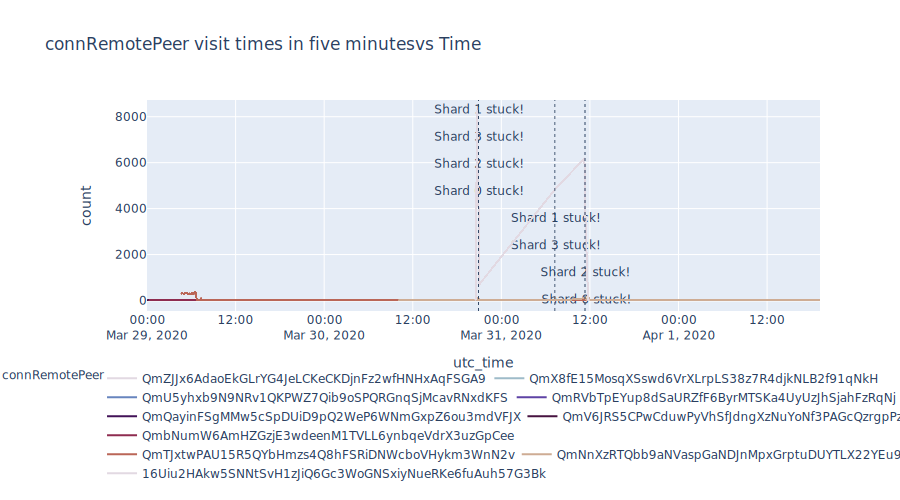

In [17]:
draw_graph(five_minute, 'connRemotePeer', alert)

### Visualize on connRemoteAddr

### get top 10 frequent address

In [18]:
lst = get_top_10_frequent(RemoteAddr, 'connRemoteAddr')
lst

['/ip4/144.91.95.131/tcp/10000',
 '/ip4/144.91.109.166/tcp/10000',
 '/ip4/5.189.148.218/tcp/10000',
 '/ip4/54.250.183.167/tcp/9000',
 '/ip4/54.213.43.194/tcp/9874',
 '/ip4/13.113.101.219/tcp/12019',
 '/ip4/79.117.176.43/tcp/10000',
 '/ip4/54.193.9.232/tcp/9000',
 '/ip4/79.117.176.43/tcp/9000',
 '/ip4/167.172.123.33/tcp/9000']

### aggregate value in five minutes

In [19]:
five_minute = aggregate_value(df, 'connRemoteAddr', lst)
five_minute

,date,connRemoteAddr,count
0,2020-03-30 20:40:00,/ip4/79.117.176.43/tcp/10000,2254
1,2020-03-31 11:15:00,/ip4/144.91.109.166/tcp/10000,2213
2,2020-03-30 20:40:00,/ip4/144.91.95.131/tcp/10000,2122
3,2020-03-31 11:20:00,/ip4/144.91.95.131/tcp/10000,2093
4,2020-03-31 11:15:00,/ip4/5.189.148.218/tcp/10000,2010
...,...,...,...
3546,2020-03-29 09:25:00,/ip4/54.250.183.167/tcp/9000,1
3547,2020-03-29 06:50:00,/ip4/54.250.183.167/tcp/9000,1
3548,2020-03-31 11:40:00,/ip4/167.172.123.33/tcp/9000,1
3549,2020-03-31 12:00:00,/ip4/167.172.123.33/tcp/9000,1


### draw graph

png graphs saved in ../../graphs/crash_analysis/mainnet/03-31/100.26.90.187-bootnode/
html graphs saved in 


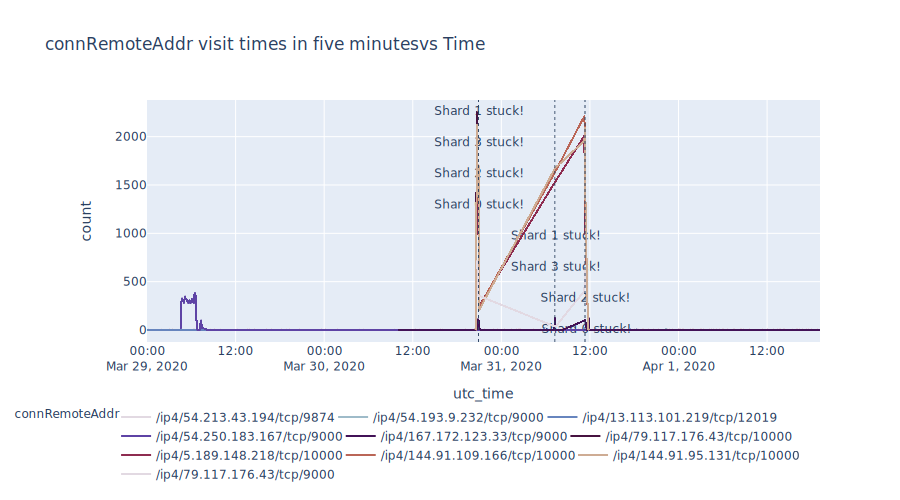

In [20]:
draw_graph(five_minute, 'connRemoteAddr', alert)